The network predicts quality scores for the individual repetitions for Exercise 1 - Deep Squat. The input to the network are the raw measurement data with 117 dimensions.

In [1]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

# The code is run on a CPU

from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Activation, Flatten, concatenate, UpSampling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import *
from keras.layers import Lambda

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now

C:\Users\Molly Meadows\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
timesteps = 40  # number of timesteps
nr = 90   # number of repetitions
n_dim = 75  # dimension of the data sequences

In [3]:
#import DataViconLoad
# Import the data
#Correct_data, Correct_label, Incorrect_data, Incorrect_label = DataViconLoad.load_data()
f = open(r'C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/smoothed_data_correct.csv', 'r')
c = csv.reader(f, delimiter = ',', quoting = csv.QUOTE_NONE)
Correct_data = np.zeros(shape = (nr, timesteps, n_dim))

# read correct data into array
i = 0
e = 0
for row in c:
    if e >= nr:
        break
    Correct_data[e, :, i % 75] = row
    i += 1
    if i % n_dim == 0:
        e += 1 # episode is done when all 75 features have been read
        
#Correct_data = np.delete(Correct_data, 40, axis = 1)
f.close()

f = open(r'C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/smoothed_data_incorrect.csv', 'r')
c = csv.reader(f, delimiter = ',', quoting = csv.QUOTE_NONE)
Incorrect_data = np.zeros(shape = (nr, timesteps, n_dim))

# read incorrect data into array
i = 0
e = 0
for row in c:
    if e >= nr:
        break
    Incorrect_data[e, :, i % 75] = row
    i += 1
    if i % n_dim == 0:
        e += 1

#Incorrect_data = np.delete(Incorrect_data, 40, axis = 1)
f.close()

f = open(r'C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\Project Learning\Scripts with Videos\Labels_Correct.csv', 'r')
c = csv.reader(f, delimiter = ',', quoting = csv.QUOTE_NONE)
Correct_label = np.zeros(shape = (nr, 1))

# read correct labels into array
i = 0
for row in c:
    Correct_label[i, :] = row
    i += 1
#Correct_data = np.delete(Correct_data, 40, axis = 1)
f.close()

f = open(r'C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\Project Learning\Scripts with Videos\Labels_Incorrect.csv', 'r')
c = csv.reader(f, delimiter = ',', quoting = csv.QUOTE_NONE)
Incorrect_label = np.zeros(shape = (nr, 1))

# read correct labels into array
i = 0
for row in c:
    Incorrect_label[i, :] = row
    i += 1
    
#Incorrect_data = np.delete(Incorrect_data, 40, axis = 1)
f.close()

# remove the final frame from each episode
timesteps = 40

# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')


(90, 40, 75) correct sequences
(90, 1) correct labels
(90, 40, 75) incorrect sequences
(90, 1) incorrect labels


In [4]:
# Split the data into training and validation sets
# Training set: 70%
# Validation set: 30%

# Sample random indices
trainidx1 = random.sample(range(0, Correct_data.shape[0]), int(nr * 0.7))
trainidx2 = random.sample(range(0, Incorrect_data.shape[0]), int(nr * 0.7))
valididx1 = np.setdiff1d(np.arange(0, nr, 1), trainidx1)
valididx2 = np.setdiff1d(np.arange(0, nr, 1), trainidx2)

# Training set: data and labels
train_x = np.concatenate((Correct_data[trainidx1, :, :], Incorrect_data[trainidx2, :, :]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]), np.squeeze(Incorrect_label[trainidx2])))
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1, :, :],Incorrect_data[valididx2, :, :]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]), np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')

(124, 40, 75) training data
(124,) training labels
(56, 40, 75) validation data
(56,) validation labels


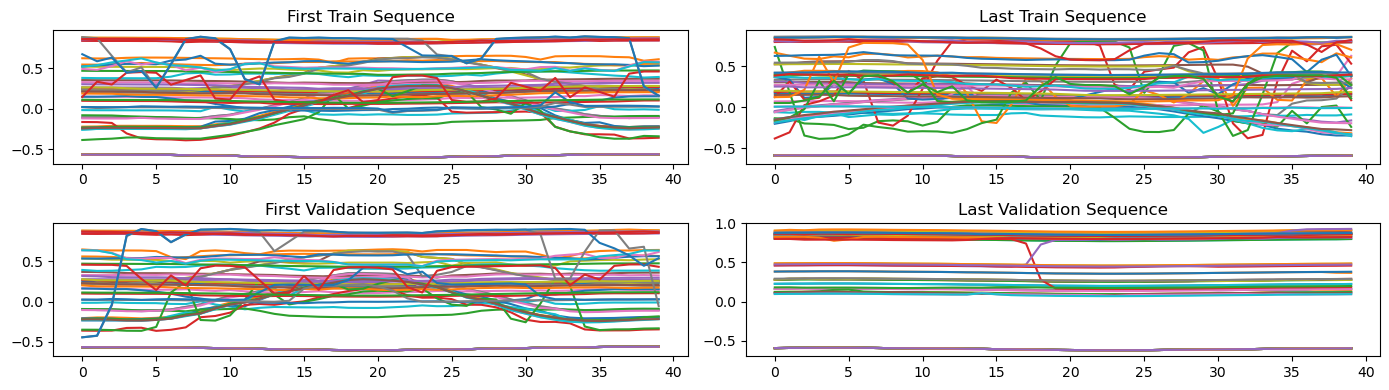

In [5]:
# Plot the first and last sequence in the training and validation sets
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

In [6]:
# Reduce the data length by a factor of 2, 4, and 8 
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
train_x_2 = np.zeros((train_x.shape[0], int(train_x.shape[1]/2), train_x.shape[2]))
valid_x_2 = np.zeros(train_x_2.shape)
train_x_4 = np.zeros((train_x.shape[0], int(train_x.shape[1]/4), train_x.shape[2]))
valid_x_4 = np.zeros(train_x_4.shape)
train_x_8 = np.zeros((train_x.shape[0], int(train_x.shape[1]/8), train_x.shape[2]))
valid_x_8 = np.zeros(train_x_8.shape)
train_x_2 = train_x[:,::2,:]
valid_x_2 = valid_x[:,::2,:]
train_x_4 = train_x[:,::4,:]
valid_x_4 = valid_x[:,::4,:]
train_x_8 = train_x[:,::8,:]
valid_x_8 = valid_x[:,::8,:]  

In [7]:
# Code to re-order the 117 dimensional skeleton data from the Vicon optical tracker into trunk, left arm, right arm, left leg and right leg
def reorder_data(x):
    X_trunk = np.zeros((x.shape[0], x.shape[1], 12))
    X_left_arm = np.zeros((x.shape[0], x.shape[1], 9))
    X_right_arm = np.zeros((x.shape[0], x.shape[1], 9))
    X_left_leg = np.zeros((x.shape[0], x.shape[1], 12))
    X_right_leg = np.zeros((x.shape[0], x.shape[1], 12))

    #since we don't have the points used b Vicon for trunk, I substituted (left and right shoulder)
    #X_trunk =  np.concatenate((x[:,:,15:18], x[:,:,6:9]), axis = 2)
    X_trunk = np.concatenate((x[:,:,3:6], x[:,:,15:18], x[:,:,6:9], x[:,:,24:27]), axis = 2)
    #No radius, Upperhand or hand joints for arms
    X_left_arm = np.concatenate((x[:,:,15:18], x[:,:,18:21], x[:,:,21:24]), axis = 2)
    X_right_arm = np.concatenate((x[:,:,6:9], x[:,:,9:12], x[:,:,12:15]), axis = 2)  

    #no right/left pelivis, femur, tibia for legs
    X_left_leg = np.concatenate((x[:,:,36:39], x[:,:,39:42], x[:,:,42:45], x[:,:,63:66]), axis = 2)
    X_right_leg = np.concatenate((x[:,:,27:30], x[:,:,30:33], x[:,:,33:36], x[:,:,72:75]), axis = 2)
    x_segmented = np.concatenate((X_trunk, X_right_arm, X_left_arm, X_right_leg, X_left_leg),axis = -1)
    return x_segmented

In [8]:
# Reorder the data dimensions to correspond to the five body parts
trainx =  reorder_data(train_x)
validx =  reorder_data(valid_x)
trainx_2 =  reorder_data(train_x_2)
validx_2 =  reorder_data(valid_x_2)
trainx_4 =  reorder_data(train_x_4)
validx_4 =  reorder_data(valid_x_4)
trainx_8 =  reorder_data(train_x_8)
validx_8 =  reorder_data(valid_x_8)

In [9]:
# Define a multibranch convolutional Inception-like block
def MultiBranchConv1D(input, filters1, kernel_size1, strides1, strides2):
    x1 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides1, padding='same', activation='relu')(input)
    x1 = Dropout(0.25)(x1)
    x2 = Conv1D(filters=filters1, kernel_size=kernel_size1+6, strides=strides1, padding='same', activation='relu')(input)
    x2 = Dropout(0.25)(x2)
    x3 = Conv1D(filters=filters1, kernel_size=kernel_size1+12, strides=strides1, padding='same', activation='relu')(input)
    x3 = Dropout(0.25)(x3)
    y1 = concatenate([x1, x2, x3], axis=-1)

    x4 = Conv1D(filters=filters1, kernel_size=kernel_size1, strides=strides2, padding='same', activation='relu')(y1)
    x4 = Dropout(0.25)(x4)
    x5 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides2, padding='same', activation='relu')(y1)
    x5 = Dropout(0.25)(x5)
    x6 = Conv1D(filters=filters1, kernel_size=kernel_size1+4, strides=strides2, padding='same', activation='relu')(y1)
    x6 = Dropout(0.25)(x6)
    x = concatenate([x4, x5, x6], axis=-1)                                                                                                                                   
    return x

In [10]:
# Define a temporal pyramid network
def TempPyramid(input_f, input_2, input_4, input_8, seq_len, n_dims):
    
    #### Full scale sequences
    conv1 = MultiBranchConv1D(input_f, 64, 3, 2, 2)

    #### Half scale sequences
    conv2 = MultiBranchConv1D(input_2, 64, 3, 2, 1)

    #### Quarter scale sequences
    conv3 = MultiBranchConv1D(input_4, 64, 3, 1, 1)

    #### Eighth scale sequences
    conv4 = MultiBranchConv1D(input_8, 64, 3, 1, 1)
    upsample1 = UpSampling1D(size = 2)(conv4)

    #### Recurrent layers
    x = concatenate([conv1, conv2, conv3, upsample1], axis=-1)
    return x    

In [11]:
#n_dim = 48 # dimension after segmenting the data into body parts
#n_dim1 = 6 # trunk dimension
n_dim = 54
n_dim1 = 12
n_dim2 = 9 # arms dimension
n_dim3 = 12 # legs dimension

# Build the model ...

#### Full scale sequences
seq_input = Input(shape = (timesteps, n_dim), name = 'full_scale')

'''
seq_input_trunk = Lambda(lambda x: x[:, :, 0:6])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 6:15])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 15:24])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 24:36])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 36:48])(seq_input)
'''

seq_input_trunk = Lambda(lambda x: x[:, :, 0:12])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 12:21])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 21:30])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 30:42])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 42:54])(seq_input)

#### Half scale sequences
seq_input_2 = Input(shape=(int(timesteps/2), n_dim), name='half_scale')

seq_input_trunk_2 = Lambda(lambda x: x[:, :, 0:12])(seq_input_2)
seq_input_left_arm_2 = Lambda(lambda x: x[:, :, 12:21])(seq_input_2)
seq_input_right_arm_2 = Lambda(lambda x: x[:, :, 21:30])(seq_input_2)
seq_input_left_leg_2 = Lambda(lambda x: x[:, :, 30:42])(seq_input_2)
seq_input_right_leg_2 = Lambda(lambda x: x[:, :, 42:54])(seq_input_2)

#### Quarter scale sequences
seq_input_4 = Input(shape=(int(timesteps/4), n_dim), name='quarter_scale')

seq_input_trunk_4 = Lambda(lambda x: x[:, :, 0:12])(seq_input_4)
seq_input_left_arm_4 = Lambda(lambda x: x[:, :, 12:21])(seq_input_4)
seq_input_right_arm_4 = Lambda(lambda x: x[:, :, 21:30])(seq_input_4)
seq_input_left_leg_4 = Lambda(lambda x: x[:, :, 30:42])(seq_input_4)
seq_input_right_leg_4 = Lambda(lambda x: x[:, :, 42:54])(seq_input_4)

#### Eighth scale sequences
seq_input_8 = Input(shape=(int(timesteps/8), n_dim), name='eighth_scale')

seq_input_trunk_8 = Lambda(lambda x: x[:, :, 0:12])(seq_input_8)
seq_input_left_arm_8 = Lambda(lambda x: x[:, :, 12:21])(seq_input_8)
seq_input_right_arm_8 = Lambda(lambda x: x[:, :, 21:30])(seq_input_8)
seq_input_left_leg_8 = Lambda(lambda x: x[:, :, 30:42])(seq_input_8)
seq_input_right_leg_8 = Lambda(lambda x: x[:, :, 42:54])(seq_input_8)

concat_trunk = TempPyramid(seq_input_trunk, seq_input_trunk_2, seq_input_trunk_4, seq_input_trunk_8, timesteps, n_dim1)
concat_left_arm = TempPyramid(seq_input_left_arm, seq_input_left_arm_2, seq_input_left_arm_4, seq_input_left_arm_8, timesteps, n_dim2)
concat_right_arm = TempPyramid(seq_input_right_arm, seq_input_right_arm_2, seq_input_right_arm_4, seq_input_right_arm_8, timesteps, n_dim2)
concat_left_leg = TempPyramid(seq_input_left_leg, seq_input_left_leg_2, seq_input_left_leg_4, seq_input_left_leg_8, timesteps, n_dim3)
concat_right_leg = TempPyramid(seq_input_right_leg, seq_input_right_leg_2, seq_input_right_leg_4, seq_input_right_leg_8, timesteps, n_dim3)

concat = concatenate([concat_trunk, concat_left_arm, concat_right_arm, concat_left_leg, concat_right_leg], axis=-1)

#not sure what these are numbers are from?
rec = LSTM(80, return_sequences=True)(concat)
rec1 = LSTM(40, return_sequences=True)(rec)
rec1 = LSTM(40, return_sequences=True)(rec1)
rec2 = LSTM(80)(rec1)

out = Dense(1, activation = 'tanh')(rec2)

model = Model(inputs=[seq_input, seq_input_2, seq_input_4, seq_input_8], outputs=out)

model.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.0001)) 

C:\Users\Molly Meadows\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
t = now()
    
early_stopping = EarlyStopping(monitor='val_loss', patience = 25)

history = model.fit([trainx, trainx_2, trainx_4, trainx_8], train_y, batch_size=3, epochs=1500, verbose=0, 
                validation_data=([validx, validx_2, validx_4, validx_8], valid_y), callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Training time: 0:07:31.303045


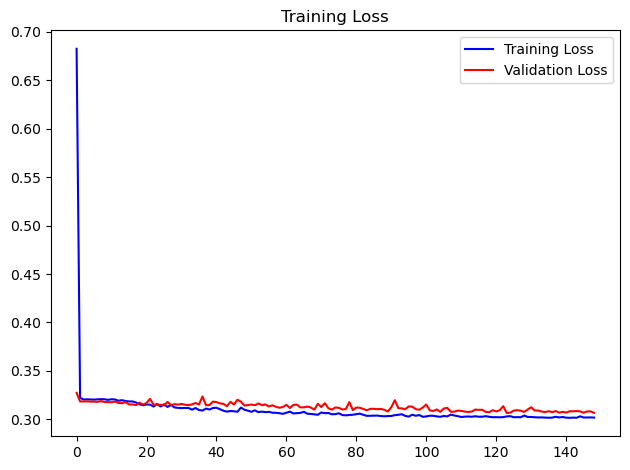

Training loss 0.30164477229118347
Validation loss 0.30664944648742676


In [13]:
# Plot the results
plt.figure(1)
plt.plot(history.history['loss'], 'b', label = 'Training Loss')
plt.title('Training Loss')
plt.plot(history.history['val_loss'], 'r', label = 'Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))    

2/2 [==============================] - 0s 29ms/step


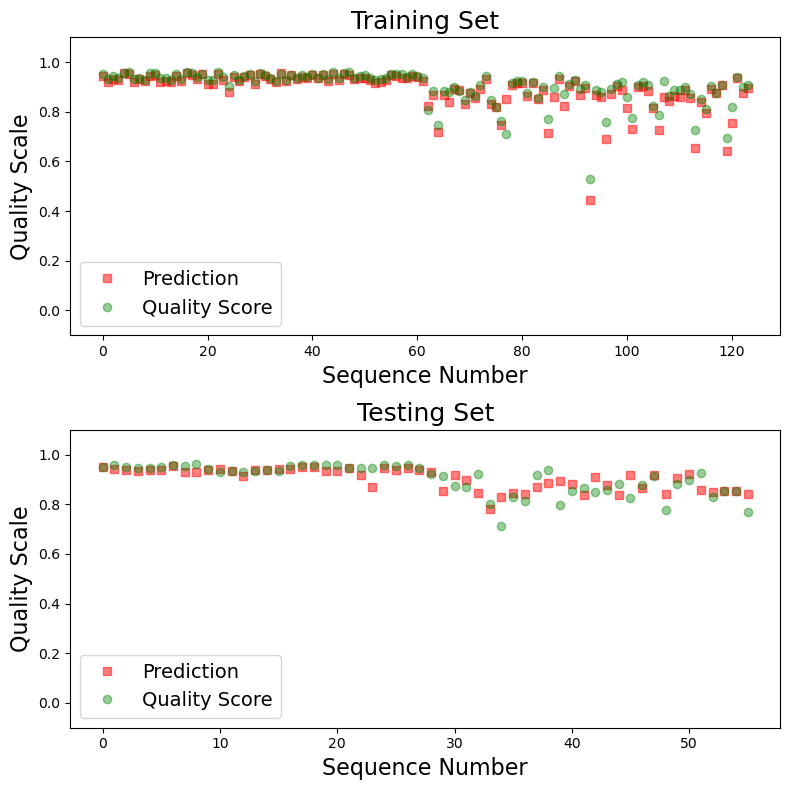

In [14]:
# Plot the prediction of the model for the training and validation sets
pred_train = model.predict([trainx, trainx_2, trainx_4, trainx_8])

pred_test = model.predict([validx, validx_2, validx_4, validx_8])

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.ylim([-0.1,1.1])
plt.title('Training Set',fontsize=18)
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.subplot(2,1,2)
plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(valid_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.title('Testing Set',fontsize=18)
plt.ylim([-0.1,1.1])
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.tight_layout()
#plt.savefig('../../Results/SpatioTemporalNN_Vicon_Scores.png', dpi=300)
plt.show()

In [15]:
# Calculate the cumulative deviation and rms deviation for the validation set
test_dev = abs(np.squeeze(pred_test)-valid_y)
# Cumulative deviation
mean_abs_dev = np.mean(test_dev)
# RMS deviation
rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
print('Mean absolute deviation:', mean_abs_dev)
print('RMS deviation:', rms_dev)

Mean absolute deviation: 0.027783483551570346
RMS deviation: 0.039232781942883106


In [16]:
import pandas as pd

#square or cube ouput values to see output

#Unit test, import videos of self doing exercise and produce accuracy score on trained model
def userTest(filename):
    test = pd.read_csv(filename, header=None)
    test = test.to_numpy()
    
    ctrain_x = np.reshape(test, (1, 40, 75))

    ctrain_x_2 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/2), ctrain_x.shape[2]))
    ctrain_x_4 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/4), ctrain_x.shape[2]))
    ctrain_x_8 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/8), ctrain_x.shape[2]))
    ctrain_x_2 = ctrain_x[:,::2,:]
    ctrain_x_4 = ctrain_x[:,::4,:]
    ctrain_x_8 = ctrain_x[:,::8,:] 

    # Reorder the data dimensions to correspond to the five body parts
    ctrainx =  reorder_data(ctrain_x)
    ctrainx_2 =  reorder_data(ctrain_x_2)
    ctrainx_4 =  reorder_data(ctrain_x_4)
    ctrainx_8 =  reorder_data(ctrain_x_8)


    #prediction
    pred = model.predict([ctrainx, ctrain_x_2, ctrain_x_4, ctrain_x_8])
    print("Your accuracy rating for " + filename + " is: ", pred)
    plt.plot(pred,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)

'''
#load and test correct data
c_test = pd.read_csv("Molly_Correct_DeepSquat.mp4_smoothed.csv", header=None)
test = c_test.to_numpy()
print(test.shape)

# Reduce the data length by a factor of 2, 4, and 8 
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
#train_x = np.concatenate((Correct_data[trainidx1, :, :], Incorrect_data[trainidx2, :, :]))
ctrain_x = np.reshape(test, (1, 40, 75))

ctrain_x_2 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/2), ctrain_x.shape[2]))
ctrain_x_4 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/4), ctrain_x.shape[2]))
ctrain_x_8 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/8), ctrain_x.shape[2]))
ctrain_x_2 = ctrain_x[:,::2,:]
ctrain_x_4 = ctrain_x[:,::4,:]
ctrain_x_8 = ctrain_x[:,::8,:] 

# Reorder the data dimensions to correspond to the five body parts
ctrainx =  reorder_data(ctrain_x)
ctrainx_2 =  reorder_data(ctrain_x_2)
ctrainx_4 =  reorder_data(ctrain_x_4)
ctrainx_8 =  reorder_data(ctrain_x_8)


#prediction
pred = model.predict([ctrainx, ctrain_x_2, ctrain_x_4, ctrain_x_8])
print("Your accuracy rating is: ", pred)
plt.plot(pred,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)

#load and test incorrect data
i_test = pd.read_csv("Molly_Incorrect_DeepSquat.mp4_smoothed.csv", header=None)
test_i = i_test.to_numpy()


itrain_x = np.reshape(test_i, (1, 40, 75))

itrain_x_2 = np.zeros((itrain_x.shape[0], int(itrain_x.shape[1]/2), itrain_x.shape[2]))
itrain_x_4 = np.zeros((itrain_x.shape[0], int(itrain_x.shape[1]/4), itrain_x.shape[2]))
itrain_x_8 = np.zeros((itrain_x.shape[0], int(itrain_x.shape[1]/8), itrain_x.shape[2]))
itrain_x_2 = itrain_x[:,::2,:]
itrain_x_4 = itrain_x[:,::4,:]
itrain_x_8 = itrain_x[:,::8,:] 

# Reorder the data dimensions to correspond to the five body parts
itrainx =  reorder_data(itrain_x)
itrainx_2 =  reorder_data(itrain_x_2)
itrainx_4 =  reorder_data(itrain_x_4)
itrainx_8 =  reorder_data(itrain_x_8)

#prediction
ipred = model.predict([itrain_x, itrain_x_2, itrain_x_4, itrain_x_8])
print("Your accuracy rating is: ", ipred)
plt.plot(ipred,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
'''

'\n#load and test correct data\nc_test = pd.read_csv("Molly_Correct_DeepSquat.mp4_smoothed.csv", header=None)\ntest = c_test.to_numpy()\nprint(test.shape)\n\n# Reduce the data length by a factor of 2, 4, and 8 \n# The reduced sequences will be used as inputs to the temporal pyramid subnetwork\n#train_x = np.concatenate((Correct_data[trainidx1, :, :], Incorrect_data[trainidx2, :, :]))\nctrain_x = np.reshape(test, (1, 40, 75))\n\nctrain_x_2 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/2), ctrain_x.shape[2]))\nctrain_x_4 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/4), ctrain_x.shape[2]))\nctrain_x_8 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/8), ctrain_x.shape[2]))\nctrain_x_2 = ctrain_x[:,::2,:]\nctrain_x_4 = ctrain_x[:,::4,:]\nctrain_x_8 = ctrain_x[:,::8,:] \n\n# Reorder the data dimensions to correspond to the five body parts\nctrainx =  reorder_data(ctrain_x)\nctrainx_2 =  reorder_data(ctrain_x_2)\nctrainx_4 =  reorder_data(ctrain_x_4)\nctrainx_8 =  reorder_

1/1 [==============================] - 2s 2s/step
Your accuracy rating for C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240405_152942054_smoothed.csv is:  [[0.9667442]]
1/1 [==============================] - 0s 16ms/step
Your accuracy rating for C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240405_153058147_smoothed.csv is:  [[0.95866346]]
1/1 [==============================] - 0s 31ms/step
Your accuracy rating for C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240405_152924506_smoothed.csv is:  [[0.9660498]]
1/1 [==============================] - 0s 39ms/step
Your accuracy rating for C:/Users/Molly Meadow

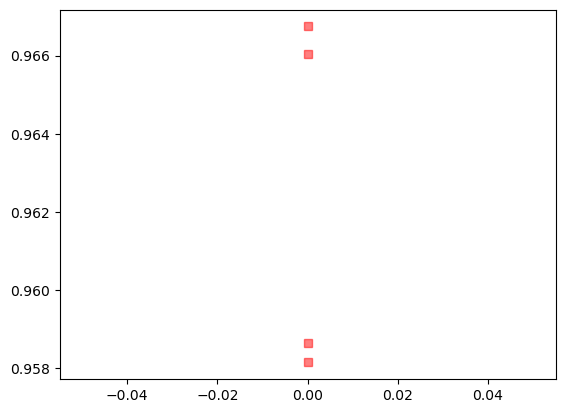

In [17]:
#new smoothed data
#userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240305_154742900_smoothed.csv")
#userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/Testing_Videos/VID_20240305_154756887.mp4_smoothed.csv")
#userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/Testing_Videos/VID_20240305_154742900.mp4_smoothed.csv")
#userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/Testing_Videos/VID_20240305_154829145.mp4_smoothed.csv")
#userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/Testing_Videos/VID_20240305_154844653.mp4_smoothed.csv")
#userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/Testing_Videos/VID_20240305_154954638.mp4_smoothed.csv")
#userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/Testing_Videos/VID_20240305_155018185.mp4_smoothed.csv")


userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240405_152942054_smoothed.csv")

userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240405_153058147_smoothed.csv")
userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240405_152924506_smoothed.csv") #good squat

userTest("C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Design Validation/SingleEpisodeTest/same_size_csvs/VID_20240405_153032758_smoothed.csv") #good squat
